# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.


## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

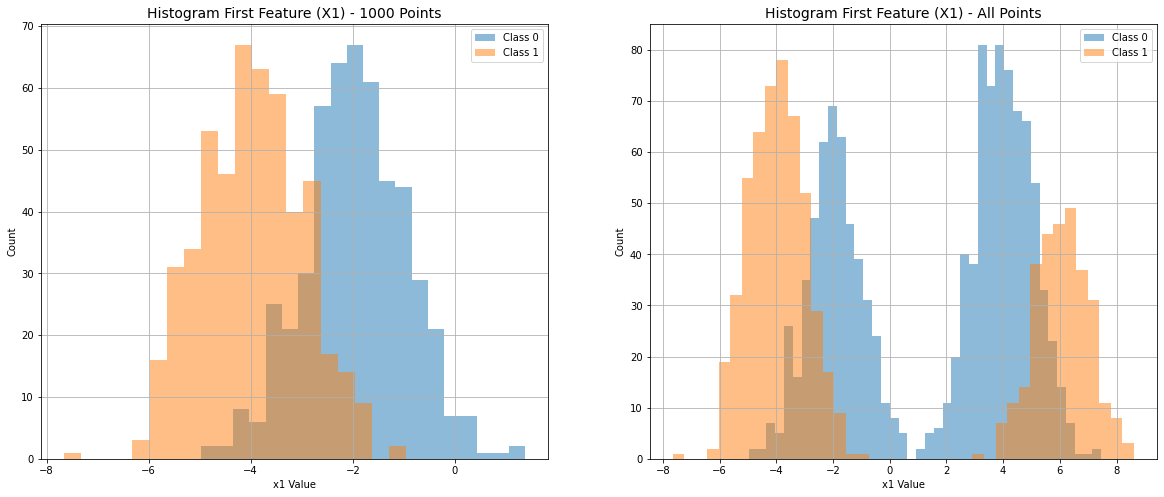

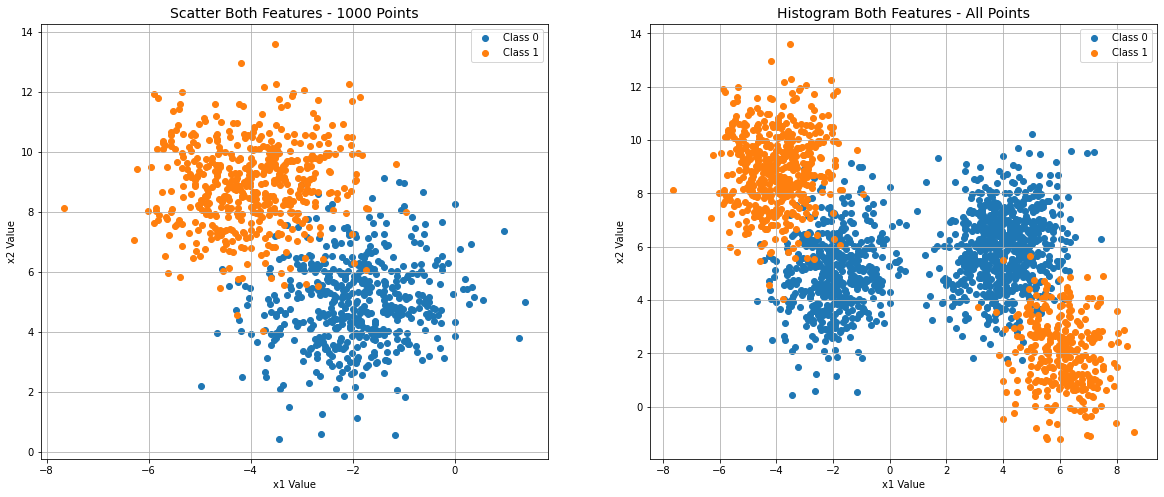

In [4]:
#### Your code here ####
#1
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
_ = axes[0].hist(training_set['x1'][:1000][training_set['y']==0], bins=20, alpha=0.5, label='Class 0')
_ = axes[0].hist(training_set['x1'][:1000][training_set['y']==1], bins=20, alpha=0.5, label='Class 1')

axes[0].set_title('Histogram First Feature (X1) - 1000 Points', fontsize=14)
axes[0].set_xlabel('x1 Value')
axes[0].set_ylabel('Count')
axes[0].grid()
axes[0].legend()

#2
_ = axes[1].hist(training_set['x1'][training_set['y']==0], bins=40, alpha=0.5, label='Class 0')
_ = axes[1].hist(training_set['x1'][training_set['y']==1], bins=40, alpha=0.5, label='Class 1')

axes[1].set_title('Histogram First Feature (X1) - All Points', fontsize=14)
axes[1].set_xlabel('x1 Value')
axes[1].set_ylabel('Count')
axes[1].grid()
axes[1].legend()
plt.show()

#3
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
_ = axes[0].scatter(training_set['x1'][:1000][training_set['y']==0], training_set['x2'][:1000][training_set['y']==0], label='Class 0')
_ = axes[0].scatter(training_set['x1'][:1000][training_set['y']==1], training_set['x2'][:1000][training_set['y']==1], label='Class 1')

axes[0].set_title('Scatter Both Features - 1000 Points', fontsize=14)
axes[0].set_xlabel('x1 Value')
axes[0].set_ylabel('x2 Value')
axes[0].grid()
axes[0].legend()

#4
_ = axes[1].scatter(training_set['x1'][training_set['y']==0], training_set['x2'][training_set['y']==0], label='Class 0')
_ = axes[1].scatter(training_set['x1'][training_set['y']==1], training_set['x2'][training_set['y']==1], label='Class 1')

axes[1].set_title('Histogram Both Features - All Points', fontsize=14)
axes[1].set_xlabel('x1 Value')
axes[1].set_ylabel('x2 Value')
axes[1].grid()
axes[1].legend()
plt.show()

## Logistic Regression


Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [5]:
def bias(X):
    """
    the functin will add first column of ones to X
    """
    size = X.shape[0]
    
    # in case that X has only one col
    if len(X.shape) == 1:
        X = X.reshape((size, 1))
                        
    ones = np.ones(size).reshape((size, 1))
    X = np.append(ones, X, axis=1)
    return X


In [6]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = []
        self.costs = []
        
    def hypotesis(self, X, theta):
        return 1 / (1 + np.exp(X.dot(-theta)))
    
    def cost(self, X, y, theta):
        h = self.hypotesis(X, theta)
#         print('i:', sum(-y * np.log(h) - (1 - y) * np.log(1 - h)) / X.shape[0])
#         print('m:', (-y.dot(np.log(h)) - np.dot((1-y), np.log(1-h))) / X.shape[0])
        return (-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) / X.shape[0]
          
    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        _, n = X.shape
        costs = [] # list to save the cost in each iteretion
        X = bias(X) # adding column of ones to X for the bias (theta_0)
        
        # initiliazed randomly the theta vector
        np.random.seed(self.random_state)
        theta = np.random.rand(n+1)
                
        for i in range(self.n_iter):
            
            # computing the theta
            h = self.hypotesis(X, theta)
            theta = theta - self.eta * X.T@(h - y)
            
            # computing the cost
            costs.append(self.cost(X, y, theta))
            
            # skip the first iteration
            if i == 0: 
                continue
                              
            # check the threshold
            if costs[i-1] - costs[i] < self.eps:
#                 print(f'stopped at iteration #{i}')
              break

        self.theta = theta
        self.costs = costs
                
    def predict(self, X):
        """Return the predicted class label"""
        
        X = bias(X) # adding column of ones to X for the bias (theta_0)
        
        if self.theta == []:
            print("fit the model first")
            return
    
        pred = self.hypotesis(X, self.theta)
        return np.array([1 if p > 0.5 else 0 for p in pred])    

    def accuracy(self, X, y):
        predictions = self.predict(X)
        return sum(predictions==y) / X.shape[0]

In [7]:
lr = LogisticRegressionGD()
lr.fit(X_training, y_training)

## Cross Validation


Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [8]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

# shuffle the training set
train_temp = np.column_stack((X_training, y_training)).astype(np.float64)

np.random.seed(1)
np.random.shuffle(train_temp)

X_training_shuf, y_training_shuf = train_temp[:,:2], train_temp[:,-1]

In [9]:
%%time
# initialized parameters
k = 5
m = X_training.shape[0]
indices = list(np.arange(m))
param_cost = {}

# creating list that will hold the size of the folds
fold_sizes = np.full(k, m // k, dtype=int)
fold_sizes[:m % k] += 1

for eta in etas:
    for eps in epss:
        avg_cost = 0
        cur = 0
        for fold_size in fold_sizes:

            # creating indexs for the split
            start, stop = cur, cur + fold_size
            val_idx = indices[start:stop]
            train_idx = indices[:start]+indices[stop:]

            # split the data
            X_val, y_val = X_training_shuf[val_idx], y_training_shuf[val_idx]
            X_train, y_train = X_training_shuf[train_idx], y_training_shuf[train_idx]

            # fit the model    
            lr = LogisticRegressionGD(eta=eta, eps=eps)
            lr.fit(X_train, y_train)

            # compute the cost and save it
            X_val = bias(X_val) # adding bias to the validation
            avg_cost += lr.cost(X_val, y_val, lr.theta)
           
            # updating the indexs
            cur = stop

        # cmputing the avg cost and saving it to param_cost dict
        avg_cost = avg_cost / k
        param_cost[(eta, eps)] = np.inf if np.isnan(avg_cost) else avg_cost
    
best_param = min(param_cost, key=param_cost.get)
print('best parameters: \neta:{}, eps:{}\n'.format(*best_param))

best parameters: 
eta:5e-05, eps:1e-06

Wall time: 1min 16s


## Normal distribution pdf


Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [10]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    part_one = 1 / (sigma * np.sqrt(2 * np.pi))
    part_two = np.exp(-0.5 * (((data - mu) / sigma)**2))
    return part_one*part_two

## Expectation Maximization


Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [11]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=2, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps

    

    def init_params(self, data):
        """
        Initialize distribution params
        """
        # Initialize w vector to be uniform of size k
        self.w = [1 / self.k] * self.k
        # Initialize distribution parameters (normal distribution has 2 params - mu and std)
        self.random_state = 42
        np.random.seed(self.random_state)
        self.mu = np.random.random(size = self.k)
        self.std = np.random.random(size = self.k)
        self.resp = []
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        if self.k==1:
          self.resp.append(norm_pdf(data, self.mu[k], self.std[k]))

        else:
          for k in range(self.k):
              self.resp.append(self.w[k] * (norm_pdf(data, self.mu[k], self.std[k])))
        
        p_total = np.add(*self.resp) 
        self.resp /= p_total

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        for k in range(self.k):
            self.w[k] = np.sum(self.resp[k,:]) / self.resp[k,:].shape[0]
            self.mu[k] = np.sum(self.resp[k,:].dot(data)) / (self.w[k] * self.resp[k,:].shape[0])
            self.std[k] = np.sqrt(np.sum(self.resp[k,:].dot((data - self.mu[k])**2)) / (self.w[k] * self.resp[k,:].shape[0]))
        self.resp = []

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        cost_ls = []
        cost_per_class = []
        
        if self.k ==1:
          self.mu = np.mean(data)
          self.std = np.std(data)
          return 
        
        for k in range(self.k):
            cost_per_class.append(self.w[k] * (norm_pdf(data, self.mu[k], self.std[k])))
        cost_ls.append(np.sum(-np.log2(np.add(*cost_per_class))))

        # two ending conditions - (1) abs(curr_cost-prev_cost) < epsilon (2) iterations <= n_iter
        for i in range(self.n_iter): # End condition #1
            cost_per_class = []
            self.expectation(data)
            self.maximization(data)
            
            for k in range(self.k):
                cost_per_class.append(self.w[k] * (norm_pdf(data, self.mu[k], self.std[k])))
            
            cost_ls.append(np.sum(-np.log2(np.add(*cost_per_class))))
            
                
            if abs(cost_ls[-2]-cost_ls[-1]) < self.eps: # End condition #2
                break
                

    def get_dist_params(self):
      return  self.mu, self.std, self.w


## Naive Bayes


Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [12]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=2):
        self.k = k
        self.labels = None
        self.features = None 
        self.num_of_labels = None 
        self.num_of_samples = None 
        self.prior = None
        self.features_stat_dic = None

    def get_prior(self, X, y):# Check if there is need for X
        """""
        Calculate the Prior staight from the Data.
        
        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values
          
        ----------
        return : Proirs by labels.
        
        """""
        priors = []
        grouped_by_lables = np.array( [ list(y[y==i]) for i in range(self.num_of_labels)] )
        self.num_of_labels = len(np.unique(y))
        for i in range(self.num_of_labels):
            prior = len(grouped_by_lables[i])/len(y)
            priors.append(prior)
        self.prior = priors
        return self.prior
    
    
    def em_parameters(self, X, y):
        """""
        Calculate the Prior staight from the Data.
        
        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values
          
        ----------
        return : Dictioniary of features and thier Statistical parameters.
        """""
        
        data = np.hstack((X,y.reshape(-1,1)))
        features_dic = {}
        
        for label in self.labels:
            label_data = data[data[:,2] == label]
            features_dic[label] = {}
            for feature in range(data.shape[1] - 1):
                em = EM(k = self.k)
                em.fit(label_data[:,feature])
                feature_params = em.get_dist_params()
                features_dic[label][feature] = [feature_params[0],feature_params[1],feature_params[2]]
        
        self.features_stat_dic = features_dic     
        return self.features_stat_dic
                
    def calc_probabilities(self, X):
        """Return the probabilities class labeled using GMM"""
        preds_val_per_class = {}
        
        for label in self.labels:
            label_stat = self.features_stat_dic[label]
            prior_vac = np.array([self.prior[label]]*len(X))
            gmm_fetures = np.array([1]*len(X))
            for l in label_stat.keys():
                gmm = self.GMM(X[:,l], label_stat[l][0],label_stat[l][1],label_stat[l][2])
                gmm_fetures = gmm_fetures * gmm
            preds_val_per_class[label] = prior_vac * gmm_fetures
        return preds_val_per_class

    
    def GMM(self, inst, mu, std, w):
        """return Calculated GMM  """
        value = np.array([0]*len(inst))
        if len(w)==1:
          value_temp = norm_pdf(inst, mu, std)
          value = value + value_temp
          return value
        for i in range((len(w))):
            value_temp = w[i]*norm_pdf(inst, mu[i], std[i])
            value = value + value_temp
        return value
    
    

    def predict(self, X):
        """Return the predicted class label"""
        predictions = []
        preds_val_per_class = self.calc_probabilities(X)
        
        for i in zip(preds_val_per_class[0],preds_val_per_class[1]):
            if i[0]>i[1]:
                predictions.append(0)
            else:
                predictions.append(1)
        return np.array(predictions)

    
    
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """

        self.labels = np.unique(y)
        self.num_of_labels = len(np.unique(y))
        self.features = X.shape[1]
        self.num_of_samples = X.shape[0]

        # calculate statistics    
        self.get_prior(X, y)
        self.em_parameters(X, y)
        
        

    def accuracy(self, X, y):
        """
        accurecy functrion
        """
        predictions = self.predict(X)
        return sum(predictions==y) / X.shape[0]
        

## Model evaluation


In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [13]:
def model_evaluation(model, X_train, y_train, X_test, y_test, logistic_costs=False):
    model.fit(X_train, y_train)
    train_acc = model.accuracy(X_train, y_train)
    test_acc = model.accuracy(X_test, y_test)
    print(f'accuracies: \ntrain: {train_acc}\ntest: {test_acc}')
    plot_decision_regions(X_train, y_train, model)
    
    if logistic_costs:
        plt.subplots(1)
        plt.plot(np.arange(len(model.costs)), model.costs)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('Cost as a function of iterations')

In [14]:
#best eta and eps

# eta, eps = best_param
eta = 5e-05
eps = 1e-06

accuracies: 
train: 0.965
test: 0.938


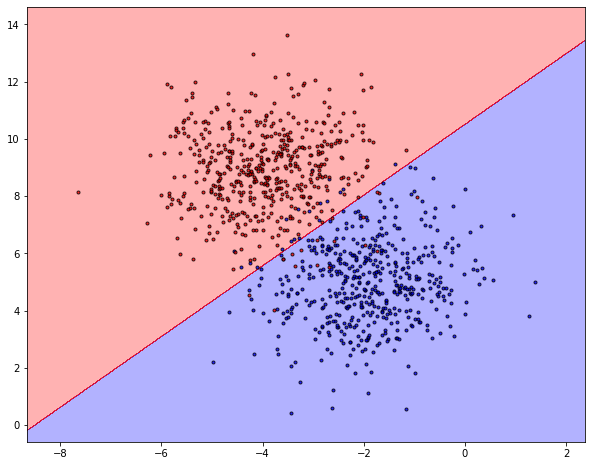

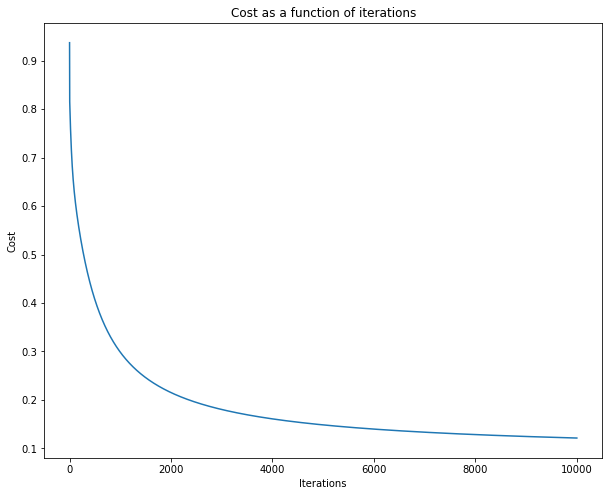

In [15]:
lr = LogisticRegressionGD(eta=eta, eps=eps)
model_evaluation(lr, X_training[:1000], y_training[:1000], X_test[:500], y_test[:500], logistic_costs=True)

accuracies: 
train: 0.966
test: 0.942


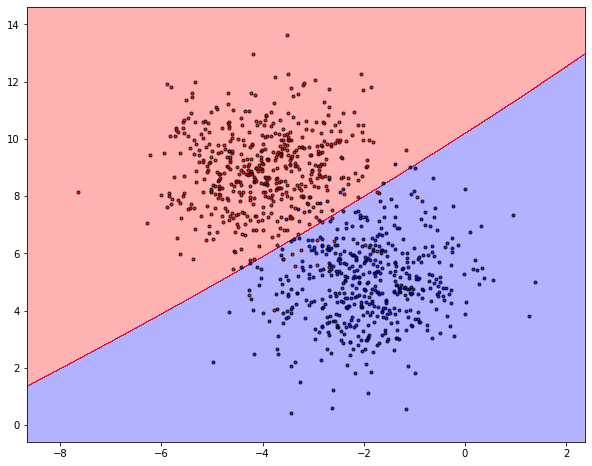

In [16]:
nb = NaiveBayesGaussian(k=1)
model_evaluation(nb, X_training[:1000], y_training[:1000], X_test[:500], y_test[:500], logistic_costs=False)

accuracies: 
train: 0.809
test: 0.804


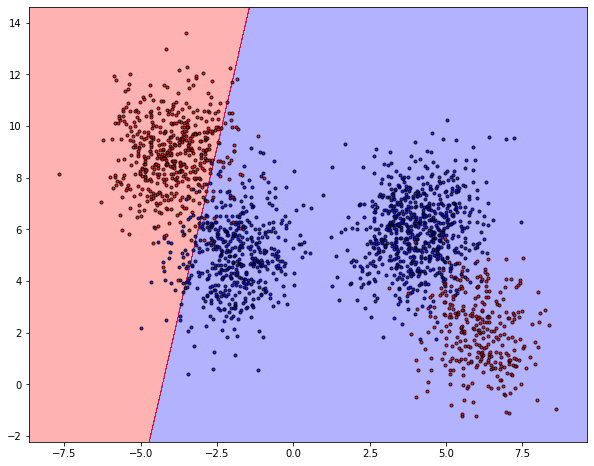

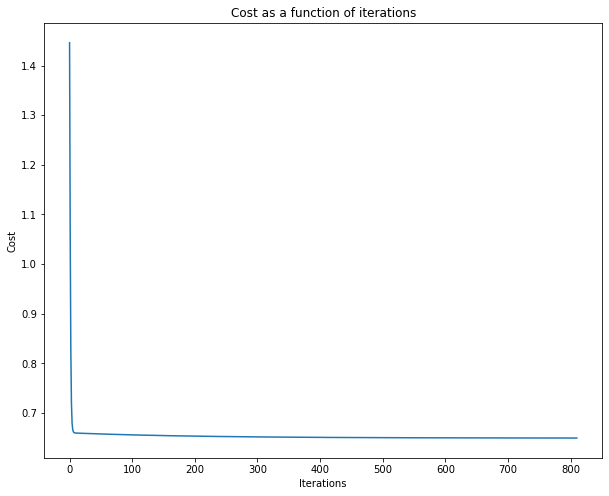

In [17]:
lr = LogisticRegressionGD(eta=eta, eps=eps)
model_evaluation(lr,X_training, y_training, X_test, y_test, logistic_costs=True)

accuracies: 
train: 0.9215
test: 0.902


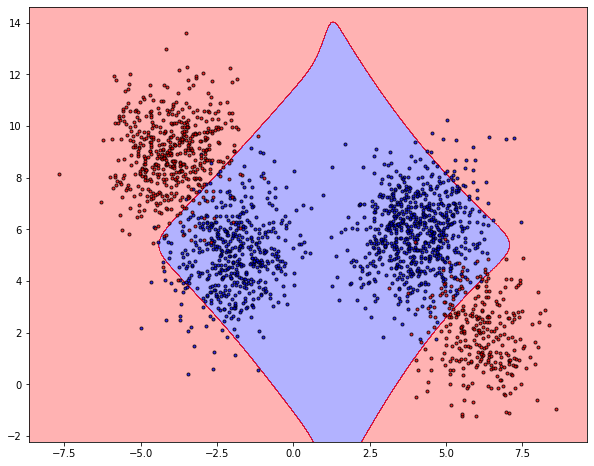

In [18]:
nb = NaiveBayesGaussian()
model_evaluation(nb, X_training, y_training, X_test, y_test, logistic_costs=False)

## Open question


1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

#### Your code and explanations here ####


 **This Data Sets Built to get better results with Logisitc Regression better than Naive Bayes.
The reason for this that the features in this dataset are depended. Naive Bayes assume that the features are indenpented and Logisitc Regression doesnt, therfore  Logisitc Regression gets better results.**

In [19]:
np.random.seed(9)
x1 = ((np.random.uniform(20, 30, 200)))
x2 = []
x2[:60] = x1[:60] + 10
x2[60:] = x1[60:] 
x = np.column_stack((x1,x2))
y1 = np.full(shape=80, fill_value=0)
y2 = np.full(shape=40, fill_value=1)
y3 = np.random.randint(2,size=40)
y4 = np.full(shape=40, fill_value=1)
y = np.concatenate((y1,y2,y3,y4))

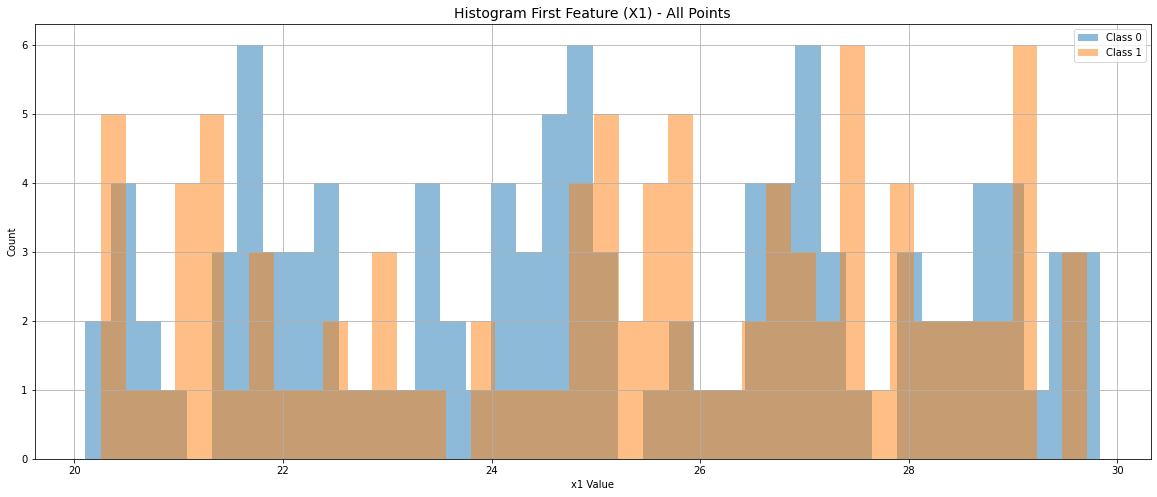

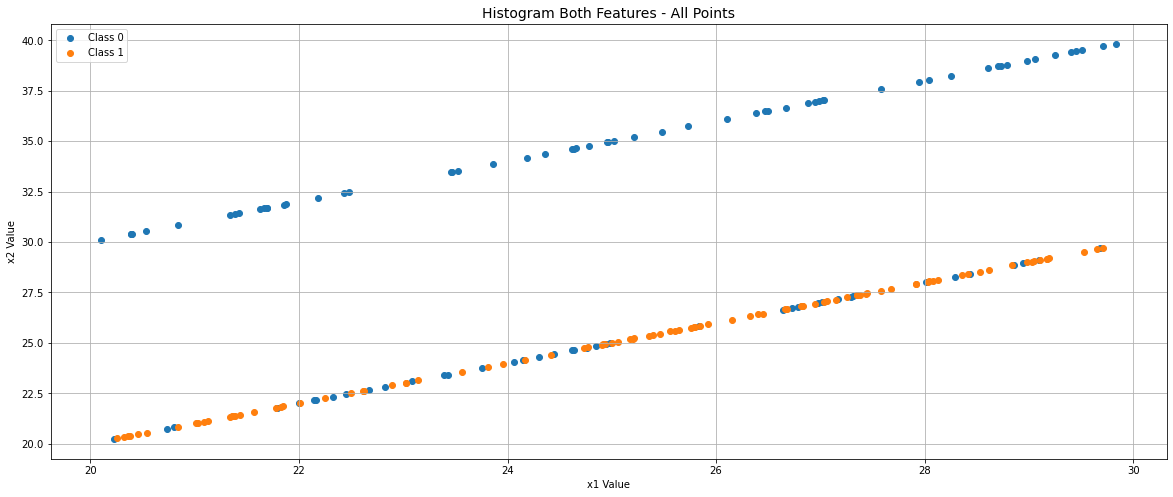

In [20]:
arr = np.arange(0,100)
np.random.shuffle(arr)
train_idx = arr[:80]
test_idx = arr[80:]

data = np.column_stack((x,y))
df = pd.DataFrame(data, columns = ['x1','x2','y'])

fig, axes = plt.subplots(1, 1, figsize=(20, 8))


_ = axes.hist(df['x1'][df['y']==0], bins=40, alpha=0.5, label='Class 0')
_ = axes.hist(df['x1'][df['y']==1], bins=40, alpha=0.5, label='Class 1')

axes.set_title('Histogram First Feature (X1) - All Points', fontsize=14)
axes.set_xlabel('x1 Value')
axes.set_ylabel('Count')
axes.grid()
axes.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(20, 8))

_ = axes.scatter(df['x1'][df['y']==0], df['x2'][df['y']==0], label='Class 0')
_ = axes.scatter(df['x1'][df['y']==1], df['x2'][df['y']==1], label='Class 1')

axes.set_title('Histogram Both Features - All Points', fontsize=14)
axes.set_xlabel('x1 Value')
axes.set_ylabel('x2 Value')
axes.grid()
axes.legend()
plt.show()

 **This Data Sets Built to get better results with Naive Bayes.
The reason for this that the features in this dataset has more than one normal disterbution in itself**

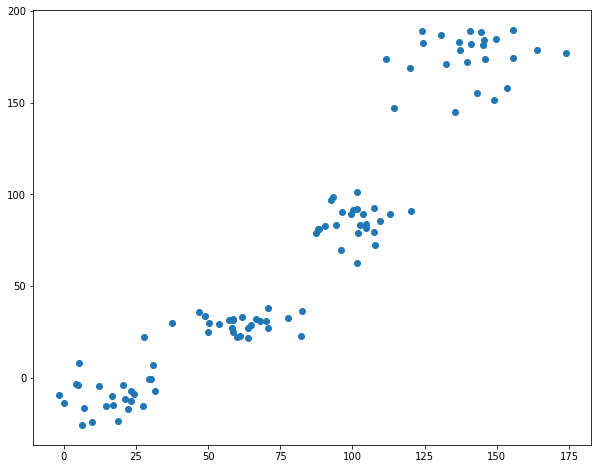

In [21]:

x1 = np.concatenate((np.random.normal(15, 10, 25), np.random.normal(60, 10, 25),np.random.normal(100, 10, 25), np.random.normal(140, 15, 25)))
# x2 = np.concatenate((np.random.uniform(20, 40, 100), np.random.uniform(140, 160, 100)))
x2 = np.concatenate((np.random.normal(-10, 10, 25), np.random.normal(30, 5, 25),np.random.normal(85, 10, 25), np.random.normal(175, 15, 25)))
x = np.column_stack((x1,x2))

y1 = np.full(shape= 25, fill_value=1)
y2 = np.full(shape= 50, fill_value=0)
y3 = np.full(shape= 25, fill_value=1)
y = np.concatenate((y1,y2,y3))
plt.scatter(x1,x2)

In [22]:
arr = np.arange(0,100)
np.random.shuffle(arr)
train_idx = arr[:80]
test_idx = arr[80:]

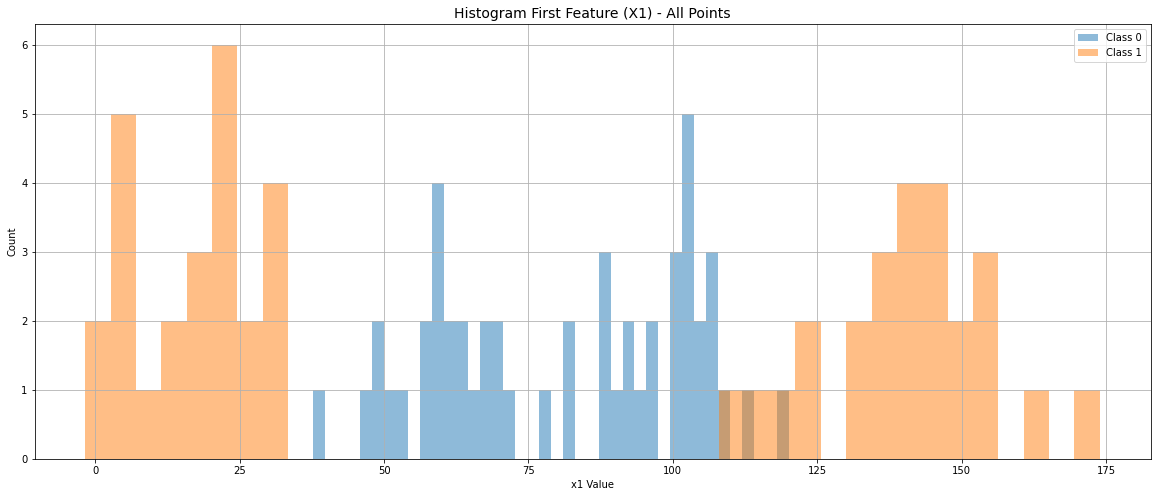

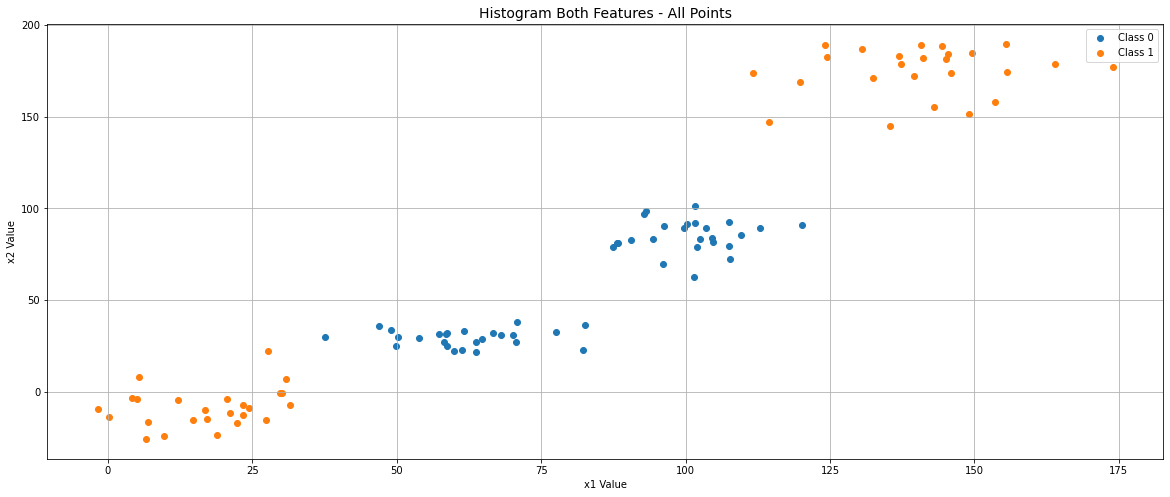

In [23]:
data = np.column_stack((x,y))
df = pd.DataFrame(data, columns = ['x1','x2','y'])

fig, axes = plt.subplots(1, 1, figsize=(20, 8))


_ = axes.hist(df['x1'][df['y']==0], bins=40, alpha=0.5, label='Class 0')
_ = axes.hist(df['x1'][df['y']==1], bins=40, alpha=0.5, label='Class 1')

axes.set_title('Histogram First Feature (X1) - All Points', fontsize=14)
axes.set_xlabel('x1 Value')
axes.set_ylabel('Count')
axes.grid()
axes.legend()
plt.show()


fig, axes = plt.subplots(1, 1, figsize=(20, 8))


_ = axes.scatter(df['x1'][df['y']==0], df['x2'][df['y']==0], label='Class 0')
_ = axes.scatter(df['x1'][df['y']==1], df['x2'][df['y']==1], label='Class 1')

axes.set_title('Histogram Both Features - All Points', fontsize=14)
axes.set_xlabel('x1 Value')
axes.set_ylabel('x2 Value')
axes.grid()
axes.legend()
plt.show()